# FFT and Reconstruction

A first idea for machine learning on this dataset is to try to use fast Fourier transorm to make useful features from time series. That's why we will first examine FFT on these time series.

Fourier showed that any periodic signal s(t) can be written as a sum of sine waves with various amplitudies, frequencies and phases [2]:

<img src="pictures/fft.png">

Results of this are amplitudes and phase shifts for frequency range from 0 to half the sampling frequency and it is covered by (N/2)+1 points where N is the size of the window i.e. number of samples. From Nyquist's theorem we know that the largest frequency component in the original signal must be half the sampling frequency. So, from a 2000 point FFT of signals sampled at 2000Hz we get 1001 unique spectral points covering the range 0 to 1000Hz.



In [1]:
import h5py                                                 #importing the h5 package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors                                #ploting with colors
import scipy.fftpack                                         #fourier tranformation
from collections import OrderedDict
import matplotlib as mpl
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

### Data import

In [2]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements  in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))


    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements  in time
    and 6291 represents number of cycles.


### Converting into SI units 

In [5]:
offset=[0, 0, 0, 0, 0.00488591, 0.00488591, 0.00488591,  0.00488591, 1.36e-2, 1.5e-2, 1.09e-2]
gain=[5.36e-9, 5.36e-9, 5.36e-9, 5.36e-9, 3.29e-4, 3.29e-4, 3.29e-4, 3.29e-4, 8.76e-5, 8.68e-5, 8.65e-5]
b=[1, 1, 1, 1, 1, 1, 1, 1, 5.299641744, 5.299641744, 5.299641744]
k=[250, 1, 10, 10, 1.25, 1, 30, 0.5, 2, 2, 2]
units=['[Pa]', '[g]', '[g]', '[g]', '[kN]', '[bar]', '[mm/s]', '[A]', '[A]', '[A]', '[A]']

sensor=[0]*len(sensorADC)

for i in range(len(sensorADC)):
    sensor[i]=((sensorADC[i]*gain[i])+offset[i])*b[i]*k[i]



In [3]:
sensor=pd.read_csv(r'C:\Users\jugo01\Desktop\sensor_units.csv')

###### If you have problems with previous step, you can skip conversion into SI units by runing next cell.

In [4]:
sensor=sensorADC

*One cycle of microphone sensor will be analysed with `FFT`.*

In [26]:
# 0 represents sensor number (microphone)
# 3000 represents cycle number from microphone
df=sensor[0][3000]


Time axis is formed based on informations about data (`0_Data_Import_and_Visualisation.ipynb`). Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

After fast Fourier transform, this signal can be represented in the frequency domain. (**Amplitude-Frequency** plot) 

In [27]:
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points

x = np.true_divide(df.index, n_of_sampling_pts)                            # time values
freq = np.fft.rfftfreq(n_of_sampling_pts, float(time)/n_of_sampling_pts)   # frequency axis
amp = np.fft.rfft(df)   


Text(0, 0.5, 'Amplitude (Pa)')

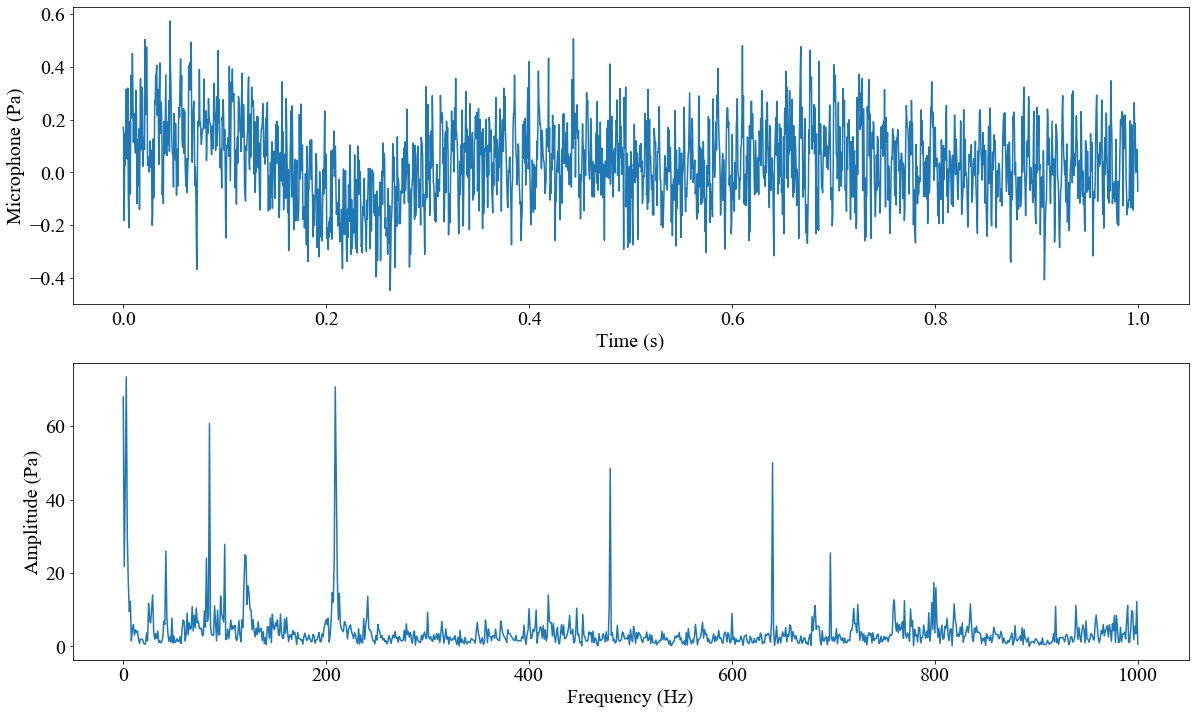

In [28]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))

plt.subplot(211)
plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")

plt.subplot(212)
plt.plot(freq,np.abs(amp))
plt.xlabel("Frequency (Hz)")  
plt.ylabel("Amplitude (Pa)")  

Because of idea to use 10% of these amplitudes for machine learning workflow, which should be enough to reconstruct the signal and make prediction, reconstruction using 10% highest amplitudes will be shown here.

Amplitudes are sorted by their absolute values from highest to lowest.

In [29]:
coeffs = dict(zip(freq, amp))

# take top N % of coefficients  !!!! This can be changed !!!!
N=10

# taking top N % aplitudes and sorting them by value, t[1] means sorting by second column i.e. by values of dictionary
out = OrderedDict(sorted(coeffs.items(), key=lambda t: abs(t[1]), reverse=True)[:round((N/100.0)*len(freq))])  

sorted_amp=list(out.values())       #transforming sorted dictionary to the list

Keeping only 10% choosen frequencies. 

In [30]:
treeshold_apsolute_amplitude=abs(sorted_amp[-1])      #choosing the treeshold amplitude

for key, value in coeffs.items():
        if abs(value) <= treeshold_apsolute_amplitude:
             coeffs[key]=0+0j
                
top_10=list(coeffs.values())

Another plot in frequency domain, will show which frequencies out of full spectrum are selected and why.

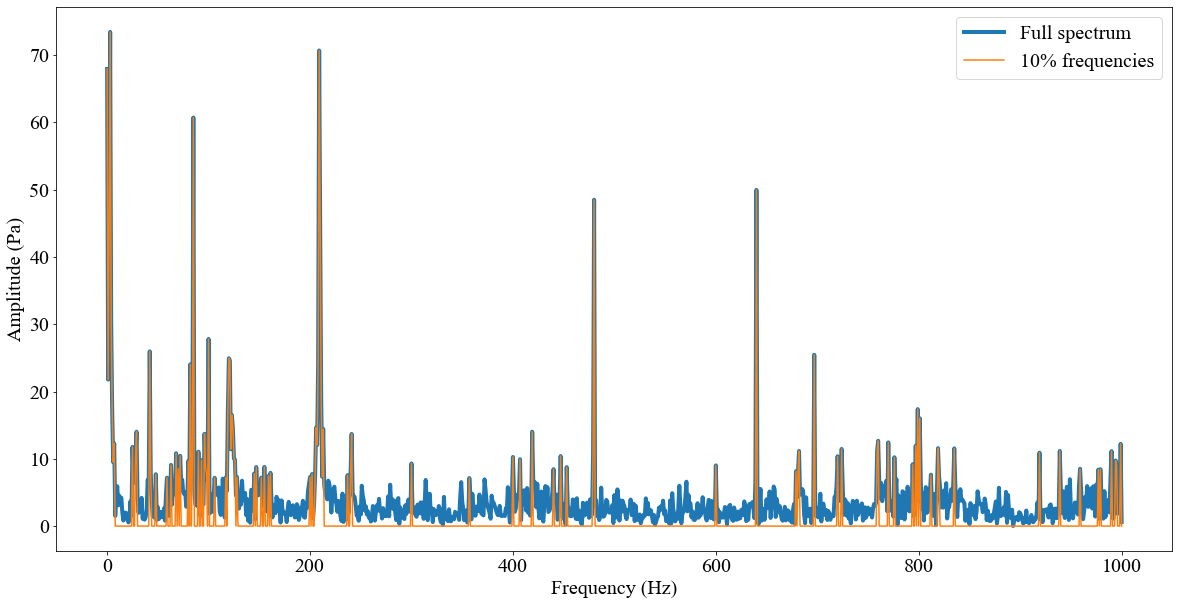

In [31]:
plt.plot(freq,np.abs(amp),zorder=1, linewidth=4,label='Full spectrum') 
plt.ylabel("Amplitude (Pa)") 

plt.plot(np.abs(top_10),zorder=2, label='10% frequencies')
plt.xlabel("Frequency (Hz)")
plt.legend()

Next plot shows sorted amplitudes, but without frequency labels.  

Text(0, 0.5, 'Amplitude (Pa)')

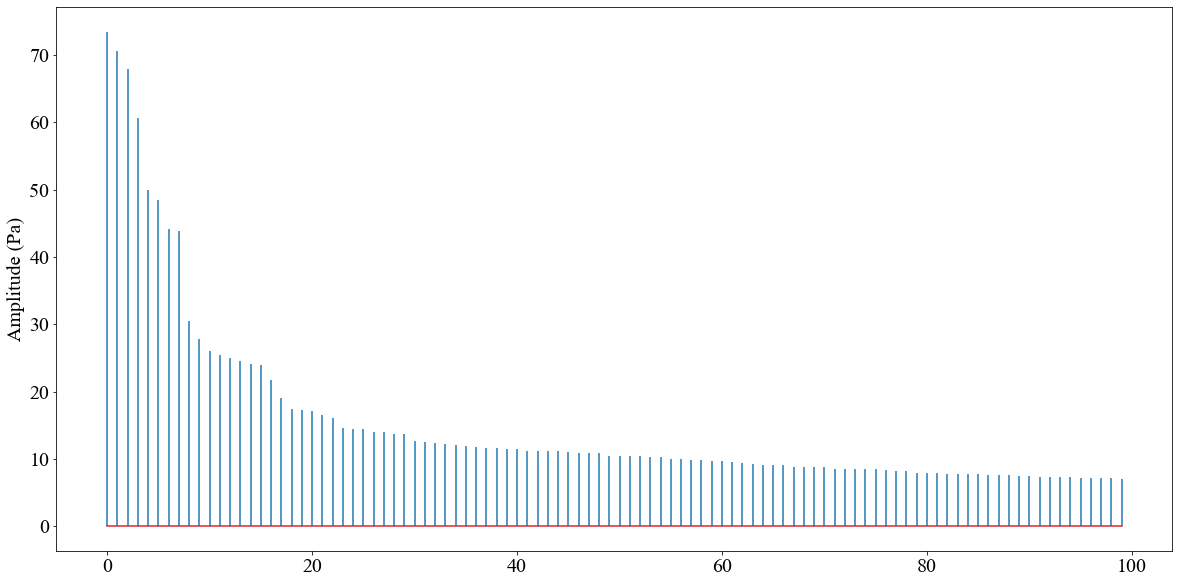

In [32]:
plt.stem(np.abs(sorted_amp), markerfmt=' ', use_line_collection=True)
plt.ylabel("Amplitude (Pa)") 

Reconstructing using inverse fast Fourier transform will give similar sensor signal, and that is why these frequencies and amplitudes are very good features for comparing different cycles.

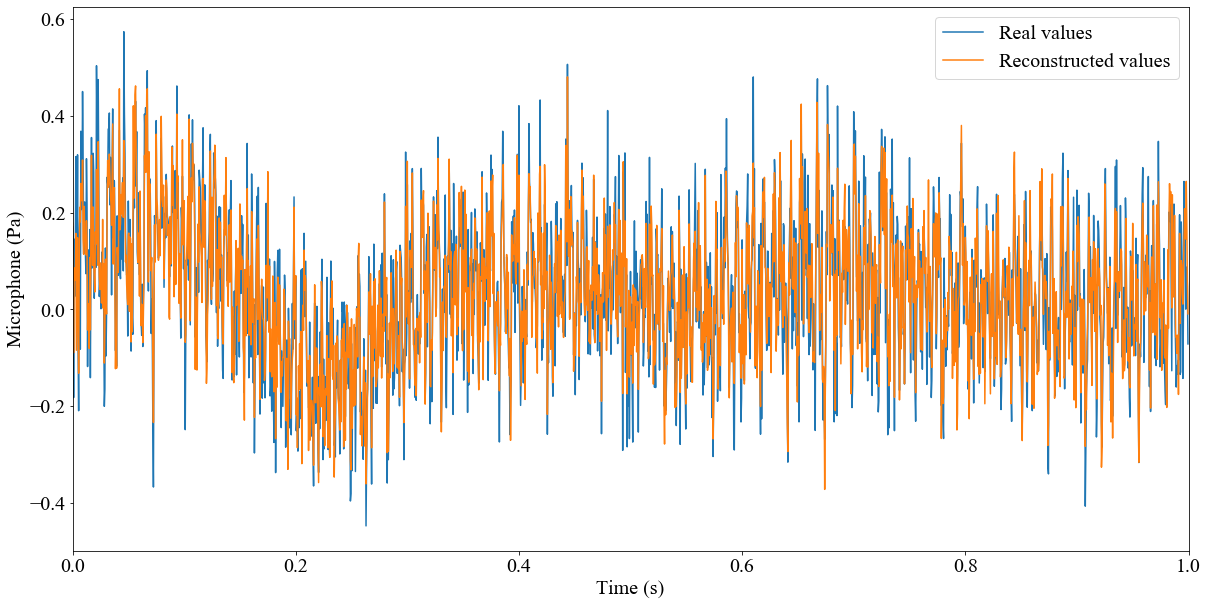

In [33]:
inverse_fft = np.fft.irfft(top_10)

plt.plot(x.values, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.plot(x.values,inverse_fft, label="Reconstructed values")
plt.xlim(0,1)
plt.legend()


This procedure can be done for every sensor and every cycle of each sensor.

## Uncertainty propagation

In order to perform uncertainty evaluation, the PyDynamic software package will be used. To install the package, write `pip install PyDynamic` on your system’s command line.[5]
The time domain signal is x with associated uncertainty ux as squared standard deviation representing noise variances (sigma²) of the signals x.

The result of the DFT is the vector X of real and imaginary parts of the DFT applied to x and the associated uncertainty UX ( covariance matrix associated with  or as a variance in the case of white noise.) When only white noise is considered, all off-diagonal elements of Ux are equal to zero. [5] 
Sampling period is 1 second, and number of points is 2000 i.e. length of this time series.

*One cycle of microphone sensor will be analysed with `DFT`.*


In [34]:
from PyDynamic import __version__ as version
version

'1.2.78'

In [35]:



sigma=float(input("Assume standard deviation:"))                           #signal noise standard deviation
sensor_num = int(input("Enter the number of sensor (0-11):"))
cycle=int(input("Enter the cycle(0-6291):"))




Assume standard deviation:0.1
Enter the number of sensor (0-11):0
Enter the cycle(0-6291):3000


In [36]:
import PyDynamic
ux=sigma**2                                                                
time = 1                                                                   # sampling period 1 s
n_of_sampling_pts=2000                                                     # sampling points
time_steps=np.arange(0, time, float(time)/n_of_sampling_pts)               # timesteps for the period (0 - 1) s
X,UX=PyDynamic.uncertainty.propagate_DFT.GUM_DFT(sensor[sensor_num][:][cycle],ux)
print("Vector X has dimensions:",X.shape)                                         # vector of real and imaginary parts
print("Vector UX has dimensions:",UX.shape)                                        # vector/covariance matrix of uncertainites
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(2000, float(time)/n_of_sampling_pts)
# frequency axis (array of length N//2 + 1 containing the sample frequencies)

Vector X has dimensions: (2002,)
Vector UX has dimensions: (2002,)


First plot represents time domain signal values. The second and third plot represent real and imaginary parts of the vector X, with their associated uncertainty. 
Note: au - arbitrary unit

Text(0.5, 0, 'frequency / Hz')

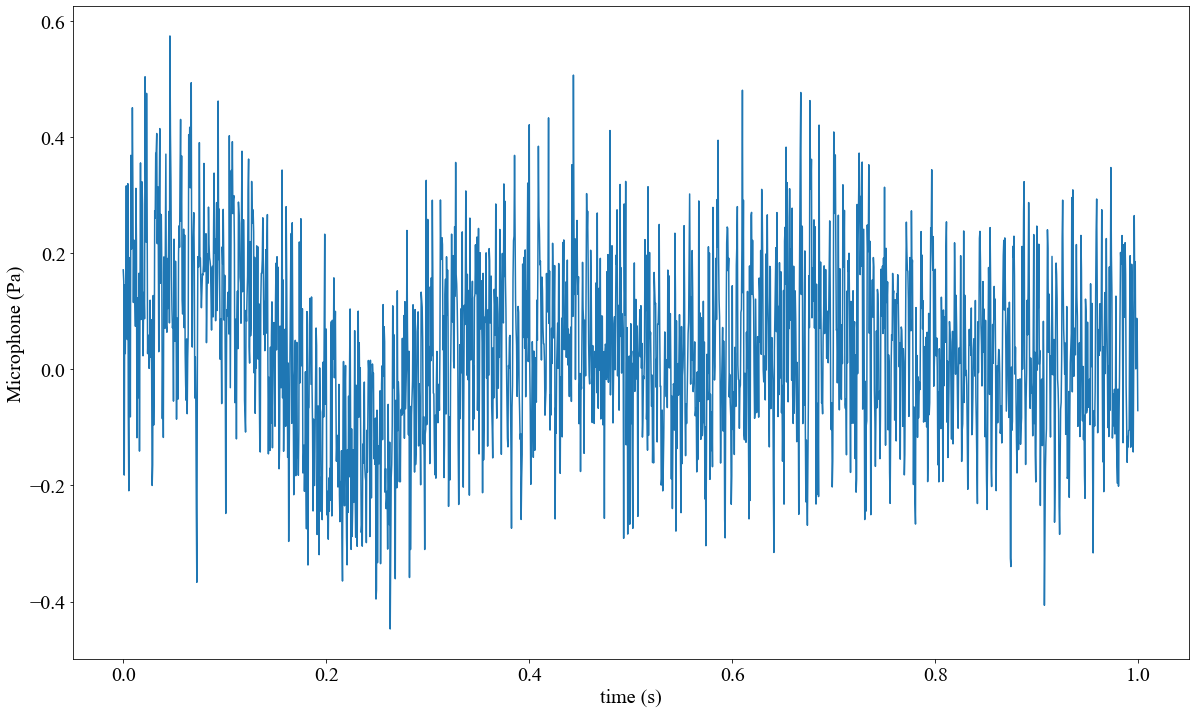

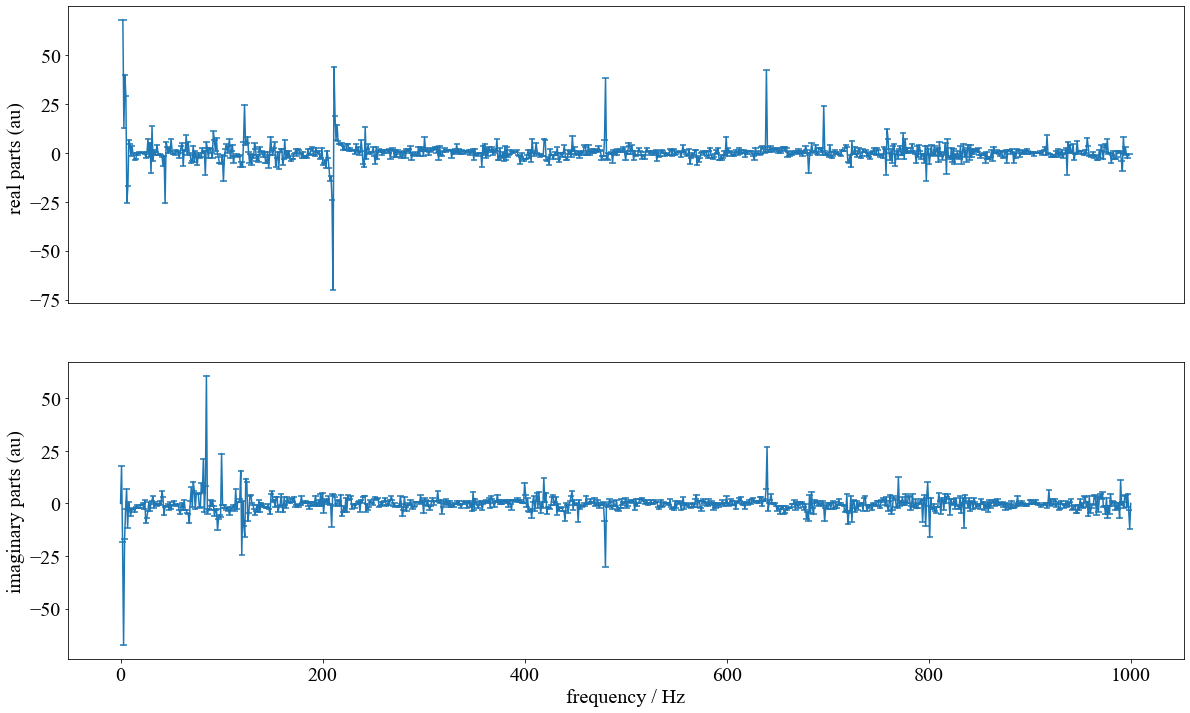

In [37]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

plt.figure(figsize=(20,12))
plt.plot(time_steps, sensor[sensor_num][:][cycle])
plt.xlabel("time (s)")
plt.ylabel("Microphone (Pa)")
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.errorbar(freq, X[:len(freq)], xerr=np.sqrt(UX[:len(freq)]))
plt.ylabel("real parts (au) ")
plt.xticks([])
plt.subplot(212)
plt.errorbar(freq, X[len(freq):], xerr=np.sqrt(UX[len(freq):]))
plt.ylabel("imaginary parts (au)")
plt.xlabel("frequency / Hz")

### Transformation from real and imaginary parts to amplitudes and phases

On the basis of vector X  and uncertainties UX, it is possible to calculate amplitudes and phases in the frequency domain, with covariance matrix of uncertainties, UAP (np.ndarray of shape (2M,2M), where M corresponds to the number of (N/2)+1 points (N - number of sampling points)). 

*Note: When amplitudes are small relative to the uncertainty associated with real and imaginary parts , the GUM uncertainty propagation becomes unreliable and a Monte Carlo method is recommended instead. Consequently, GUM2DFT does raise a warning to the user and recommends using a Monte Carlo method instead whenever an element of  is below a pre-defined threshold. The default threshold in GUM2DFT is 1.0, but may be adjusted for specific applications.[7]*



In [39]:
A,P,UAP=PyDynamic.uncertainty.propagate_DFT.DFT2AmpPhase(X, UX, keep_sparse=False, tol=1.0, return_type='separate')

DFT2AmpPhase Warning
 Some amplitude values are below the defined threshold.
The GUM formulas may become unreliable and a Monte Carlo approach is recommended instead.
The actual minimum value of A/uF is 7.41e-03 and the threshold is 1.00e+00


In this case, UAP matrix is dense matrix. Operations using standard dense-matrix structures and algorithms are slow and inefficient when applied to large sparse matrices as processing and memory are wasted on the zeroes. If matrix has large dimensions, sparse data is by nature more easily compressed and thus requires significantly less storage [6]. Amplitudes and phases with their uncertainties are shown on the following plots:

C:\Users\Ehlimana\Anaconda3\envs\ZEMA\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


Text(0, 0.5, 'Phase (degrees)')

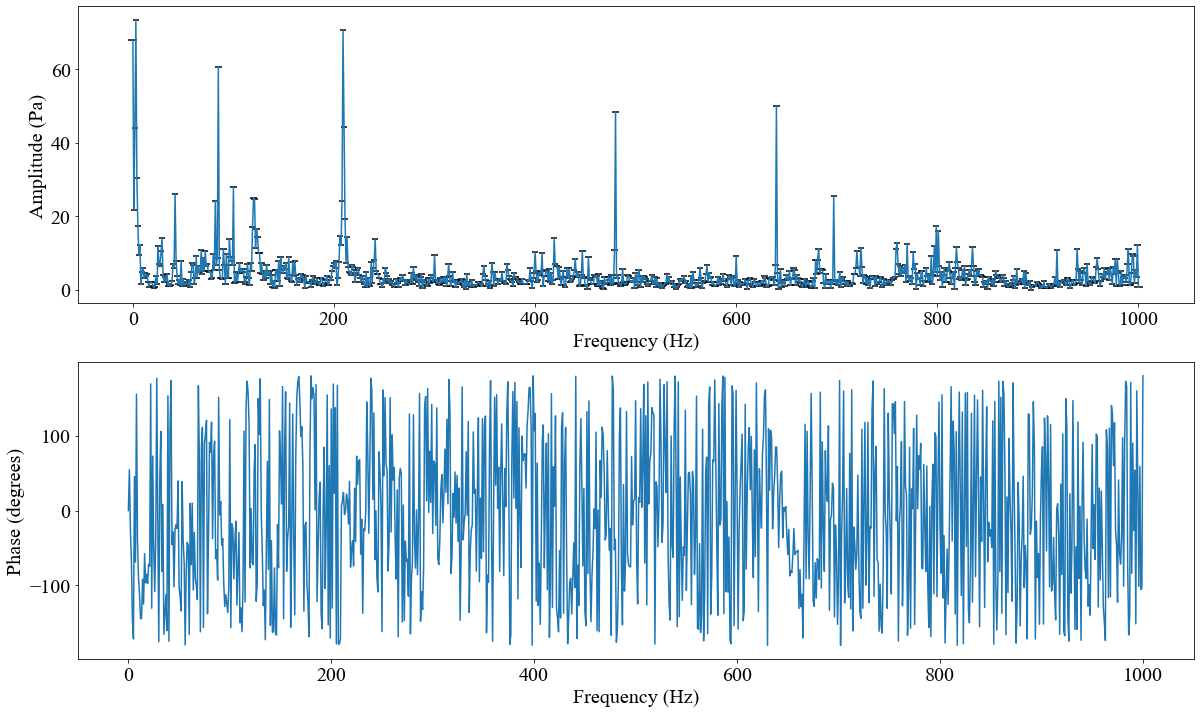

In [40]:
plt.figure(figsize=(20,12))
plt.subplot(211)

plt.errorbar(freq, np.abs(A),xerr=np.sqrt(np.diag(UAP[:1001])),yerr=np.diag(UAP[:1001,1001:]), ecolor='black') #other diagonals are zero
plt.ylabel("Amplitude (Pa)") 
plt.xlabel("Frequency (Hz)")
plt.subplot(212)
plt.errorbar(freq, P*180/np.pi,xerr=np.sqrt(np.diag(UAP[1001:])),ecolor='black')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees)")   

### Reconstruction of time domain signals


Reconstruction using 10% highest amplitudes can be also made with iDFT function or AmpPhase2Timefrom PyDynamic.
From real and imaginary parts contained in vector X, amplitudes can be calculated as
$A=\sqrt{Re²+Im²}$

Indices of 10% of highest amplitudes are found by function `np.argsort`.

Values of real and imaginary parts of 10% highest amplitudes are assigned to vector F, on the indices that correspond N% of highest amplitudes. Other values are considered as zeros.

Values of uncertainties of real and imaginary parts of 10% highest amplitudes are assigned to vector UF, on the indices that correspond N% of highest amplitudes. Other values are considered as zeros.

In [41]:
def reconstructed_signal_with_iDFT(X,UX,N):
    Amplitudes=[]
    range_F=UX.shape[0]-2
    for i in range(range_F//2):
        Amplitudes.append(np.sqrt(X[i]**2+X[range_F//2+i]**2)) #calculating amplitudes
    Sorted_amplitudes=np.argsort(Amplitudes)[::-1] # indices of amplitudes in descending order
    N_highest_amplitudes=Sorted_amplitudes[:N]
    F=np.zeros(len(X)) #Vector (2*len(X),)
    UF=np.zeros(len(X)) #Vector (2*len(X),)
    for i in N_highest_amplitudes:
        F[i]=X[i] # assigned real parts on indices of amplitudes 
        F[i+range_F//2+1]=X[i+range_F//2+1] # assigned imaginary parts on indices of amplitudes 
        UF[i]=UX[i] # assigned uncertainties of real parts on indices of amplitudes 
        UF[i+range_F//2+1]=UX[i+range_F//2+1] # assigned uncertainties of imaginary on indices of amplitudes 
    x,ux=PyDynamic.uncertainty.propagate_DFT.GUM_iDFT(F, UF, Nx=None, Cc=None, Cs=None, returnC=False)
    return x,ux


In [42]:
N=int(input("Enter the percentage of choosen amplitudes (0-100):"))
x1,ux1=reconstructed_signal_with_iDFT(X,UX,N)

Enter the percentage of choosen amplitudes (0-100):10


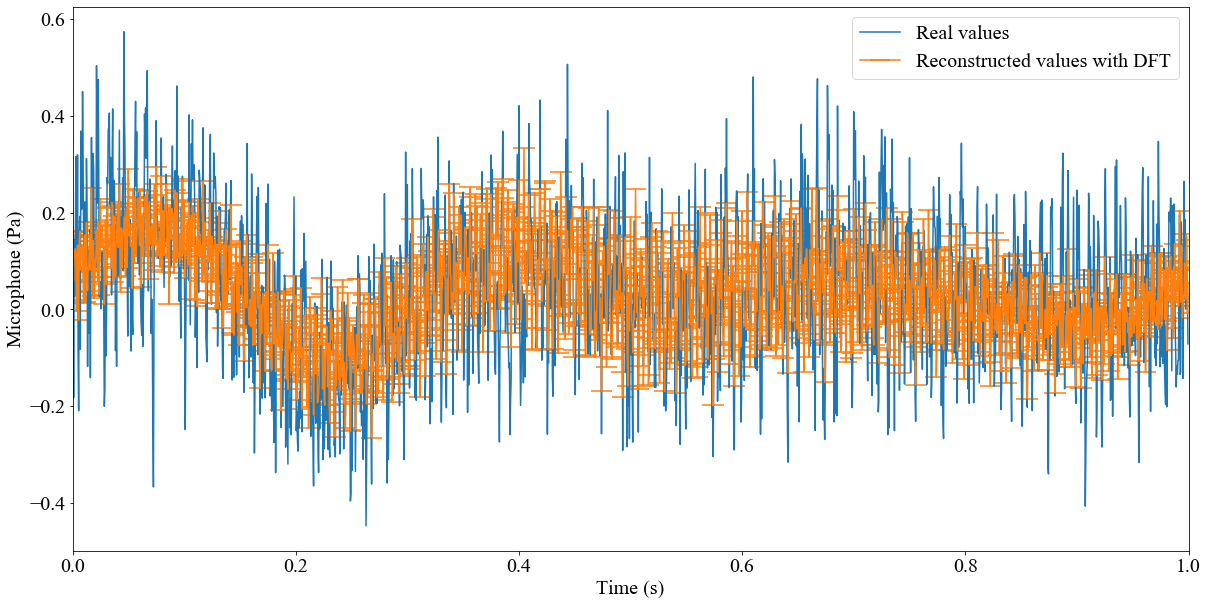

In [43]:
plt.plot(time_steps, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.errorbar(time_steps,x1,xerr=np.sqrt(np.diag(ux1)),label="Reconstructed values with DFT")

plt.xlim(0,1)
plt.legend()

Reconstruction using 10% highest amplitudes can be also made with AmpPhase2Time from PyDynamic.
Indices of 10% of highest amplitudes are found by function `np.argsort`.

Values of phases that correspond to 10% highest amplitudes are assigned to vector P, on the indices of N% of highest amplitudes. Other values are considered as zeros.

Values of uncertainties of amplitudes and phases that correspond to 10% highest amplitudes are assigend to vector UAP, on the indices that correspond N% of highest amplitudes. Other values are considered as zeros.

In [44]:
def reconstructed_signal_with_AmpPhase2Time(amplitudes,phases,uncertainties,N):
    Amplitudes=amplitudes
    Phases=phases
    Uncert=uncertainties
    Index_amplitudes=np.argsort(Amplitudes)[::-1]        # indices of amplitudes in descending order
    N_highest_amplitudes=Index_amplitudes[:N]
    A=np.zeros(len(Amplitudes)) 
    P=np.zeros(len(Amplitudes))
    UAP=np.zeros(Uncert.shape)
    range_F=N = Uncert.shape[0]-2
    for i in N_highest_amplitudes:
        A[i]=Amplitudes[i] # assigned values of amplitudes on indices of N% amplitudes 
        P[i]=Phases[i]  # assigned values of phases on indices of N% amplitudes 
        UAP[i,i]=Uncert[i,i]                             # Covariance matrix contains uncertainties of amplitudes, phases and 
        UAP[i,i+range_F//2+1]=Uncert[i,i+range_F//2+1]   # covariance uncertainties of amplitudes and phases.
        UAP[i+range_F//2+1,i+range_F//2+1]=Uncert[i+range_F//2+1,i+range_F//2+1]         
    x,ux=PyDynamic.uncertainty.propagate_DFT.AmpPhase2Time(A,P,UAP)
    return x,ux


In [45]:
D=int(input("Enter the percentage of choosen amplitudes (0-100):"))
x2,ux2=reconstructed_signal_with_AmpPhase2Time(A,P,UAP,D)

Enter the percentage of choosen amplitudes (0-100):10


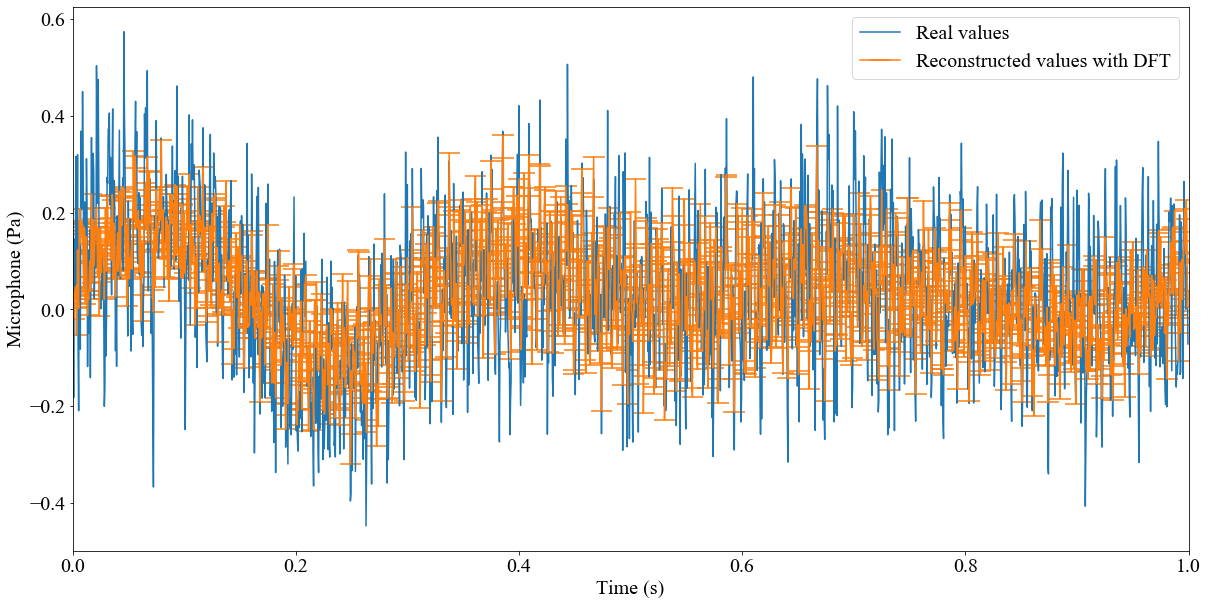

In [46]:
plt.plot(time_steps, df, label="Real values")
plt.ylabel("Microphone (Pa)")
plt.xlabel("Time (s)")
plt.errorbar(time_steps,x2,xerr=np.sqrt(np.diag(ux2)),label="Reconstructed values with DFT")

plt.xlim(0,1)
plt.legend()

### References:

[1]  PTB, ZeMA, - Deep dive into the ZeMA machine learning (ppt), January 2019

[2]  https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft

[3]  http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

[4]  https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

[4]  Edouard Duchesnay, Tommy Löfstedt, - Statistics and Machine Learning in Python, March 2018

[5]  https://pydynamic.readthedocs.io/en/master/Getting%20started.html#quick-examples

[6]  https://en.wikipedia.org/wiki/Sparse_matrix

[7] S Eichstädt and V Wilkens, - GUM2DFT—a software tool for uncertainty evaluation of transient signals in the frequency domain, March 2016 

In [55]:
UAP_2[0:5,0:5]

array([[20.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])